**음성 데이터 학습을 통한 성별 분류 모델 만들기**  
- 이진 분류 모델 (binary classifier)
- Pitch : 성별 분류로 잘 알려진 음향 특징

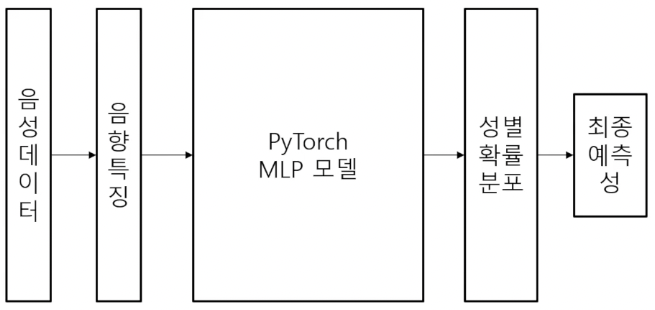

음성 데이터 준비
1. 동영상 공유 플랫폼 - 음원 추출   
Praat를 사용하여 발화 구간 분절 및 개별 저장  
음성 형식 변환 (통일성)

2. 직접 녹음  
마이크  
음성 형식 변환

3. 음성 코퍼스 활용  
공개/비공개 음성 코퍼스 데이터 활용  
필요 시 음성 형식 변환



AIHub  
한국어 대화체 데이터 : https://aihub.or.kr/aihub-data/natural-language/about
  
        
* 데이터 분포
Train : 남성, 여성 발화 샘플 각 298개 (298명)  
Test : 남성, 여성 발화 샘플 각 1개 (Train의 화자와 겹치지 않음)  
모든 샘플은 1~5초 길이의 음성
* 음성 형식 변환  
채널 수: 1 (mono)  
샘플 수 : 8KHz  
Peak Scailing: 0.99 # 소리가 작은 상태인 것 키움
* 음성 데이터  
AUDIO_DATA.zip 참고

음향 특징 추출
* Pitch (F0, 기본주파수)  
성별과 관련된 음향 특징  
음성(목소리)의 높낮이: 대체로 여성 > 남성  
* Python의 음향 특징 추출 라이브러리 사용  
프레임별 Pitch 값 추출  
음성 구간 전체의 Pitch 값의 평균 및 편차 계산 (통계치 측정)  

In [ ]:
!unzip -n "/content/drive/MyDrive/aiotmooc/음성 13차시.zip" # n: 덮어쓰기 X
# !unzip -qq "/content/drive/MyDrive/aiotmooc/음성 13차시.zip" -d "./"

Archive:  /content/drive/MyDrive/aiotmooc/음성 13차시.zip


In [ ]:
# 음성 파일 읽어서 파형 표현
import librosa # 음향 특징 추출 라이브러리
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
audio_name = "test.wav" # 한 개의 샘플

y, sr = librosa.load(audio_name, sr=8000) # y : 에너지, sr : sampling rate (샘플 수)
print("Num of sample:", len(y))
print("Time:", len(y)/8000) # 초당 8K → 1~2s 사이

Num of sample: 12952
Time: 1.619


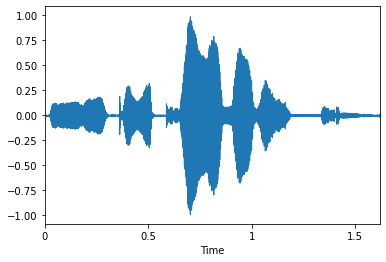

In [ ]:
librosa.display.waveplot(y, sr=sr)

In [ ]:
f0, _, _ = librosa.pyin(y, fmin=10, fmax=400, # Hz
                        frame_length=512,
                        win_length=200, hop_length=80)

In [ ]:
print(f0) # nan : scilence 구간 혹은 설정값 외의 주파수(frequency) 

[         nan          nan          nan          nan          nan
 298.57055729 295.14118195 290.0708331  286.73908541 286.73908541
 286.73908541 290.0708331  293.44129383 295.14118195 296.85091742
 300.30015893 302.03978006 303.7894787  305.54931325 307.31934242
 305.54931325 305.54931325 309.09962526 314.50259153 321.85374114
 321.85374114 316.32448651 312.6911899  309.09962526 305.54931325
 298.57055729 286.73908541 280.18995565          nan          nan
          nan          nan          nan          nan          nan
 340.99216052 339.02819019 335.1341193  327.47964544 318.15693562
 310.89022117 307.31934242 307.31934242 309.09962526 309.09962526
 309.09962526 307.31934242 305.54931325 300.30015893          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan 285.0875898  288.40014804 290.0708331
 291.75119634 291.75119634 290.0708331  290.0708331  286.73908541
 283.445606

In [ ]:
import numpy as np

mean_f0 = np.nanmean(f0) # nan 을 제외한 나머지 숫자들의 평균
mean_f0

297.48692130242745

In [ ]:
std_f0 =np.nanstd(f0)
std_f0

34.369268307870925

In [ ]:
# 각 성별별로 298개 샘플
# mean 값, standard deviation 값을 한 쌍씩 가져온 형태로 준비 됨
data_file_name = "all_f0.txt" 

dataset = []

f = open(data_file_name, 'r')

for line in f.readlines(): # line 별로 읽어옴
  line = line.strip() # 줄바꿈 문자 제거
  
  # mean, std, label
  m = float(line.split()[0]) # text to float
  s = float(line.split()[1])
  l = int(line.split()[2])
  dataset.append([[m, s], l]) # 음성 특징 값과 label 값 분리

# 첫 번째 샘플(남성)과 마지막 샘플(여성)
train_dataset = dataset[1:-1]
test_dataset = [dataset[0], dataset[-1]] 

In [ ]:
test_dataset

[[[113.10633961574324, 22.60795757927473], 0],
 [[192.06517989419362, 33.15100719458566], 1]]

In [ ]:
import random
random.shuffle(train_dataset)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.init import kaiming_uniform_
# kaiming_uniform_ : 초기화 함수. 없어도 되나, weight/bias 값들이 터무니없는 값이 아닌 이 layer와 관련된 (랜덤)값이 되도록 함 -> 학습 속도 개선

In [ ]:
class MLP(nn.Module):
  
  def __init__(self, input_size, hidden_size): # input_size : 음향 특징의 개수 (mean, std 의 2가지)
    super(MLP, self).__init__()
    self.hidden_size = hidden_size # forward 함수에서도 사용 가능하게끔

    self.fc1 = nn.Linear(input_size, hidden_size)
    kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
    # 활성 함수(비선형 함수)는 ReLU 사용을 정의 - forward 함수 내에서 사용해주는 식으로 진행
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
    self.fc3 = nn.Linear(hidden_size, 1)

  def forward(self, x):

    x = self.fc1(x) # input -> hidden
    x = F.relu(x)

    x = self.fc2(x)
    x = F.relu(x)
    
    x = self.fc3(x) # hidden -> 1(output)
    # 비용함수 X

    return x

In [ ]:
# training
torch.manual_seed(777)

model = MLP(input_size=2, hidden_size=16)
model.cuda() # ***GPU 사용

# binarycrossentropy, WithLogitsLoss : sigmoid를 효율적으로 계산 해주기 때문에 앞에서 비용함수 안 쓴 것
criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # global minima 로 모이는 속도가 빨라서 많이 사용, lr 기본값

model.train() 
# model.train = eval (evaludation)
# 학습할 단계 -> gradient update(parameter) 준비 vs eval 은 학습할 단계가 아니다

epochs = 15 # 반복 학습

for epoch in range(epochs):
  for x, y in train_dataset: # m s, label 
    x = torch.FloatTensor(x).unsqueeze(0).cuda()
    y = torch.FloatTensor([y]).unsqueeze(0).cuda() # data 형태를 맞춰 준 것

    # gradient 초기화 : 이전에 학습된 값이 새로 학습하는 데 영향을 주면 안되기 때문
    optimizer.zero_grad()

    output = model(x)

    loss = criterion(output, y) # 예측값, 정답값 간의 오차

    loss.backward() # backpropagation : 오차가 어디서 영향을 받은건지 알 수 있는 단계 (편미분)

    optimizer.step() # (편미분을 통해)어디의 값을 바꿔야 하는지 나온 것들 다 반영 - 다음 단계 준비
    # 여기 까지가 하나의 학습 (전체 데이터를 한 번 다 훑음)

  print("Epoch: {}: {}".format(epoch+1, loss.item()))

Epoch: 1: 1.3599441051483154
Epoch: 2: 0.5677778720855713
Epoch: 3: 0.49337977170944214
Epoch: 4: 0.5557665228843689
Epoch: 5: 0.4109020531177521
Epoch: 6: 0.30994027853012085
Epoch: 7: 0.23739226162433624
Epoch: 8: 0.17991036176681519
Epoch: 9: 0.13343839347362518
Epoch: 10: 0.0914904922246933
Epoch: 11: 0.06342103332281113
Epoch: 12: 0.04236914590001106
Epoch: 13: 0.03040063939988613
Epoch: 14: 0.0220768004655838
Epoch: 15: 0.01375776156783104


In [ ]:
model.eval() # 평가하는 단계(학습 X) : gradient 업데이트 안함

print("Test Dataset", test_dataset, "\n")

with torch.no_grad():
  for x, y in test_dataset:
    print(x)
    x = torch.FloatTensor(x).unsqueeze(0)
    x = Variable(x, requires_grad=False).cuda() # 없어도 큰 차이는 없는데, pytorch에서 만든 기능이기 때문에 안정면에서 써 줌

    y = torch.FloatTensor([y]).unsqueeze(0)
    y = Variable(y).cuda()

    output = model(x)

    loss = criterion(output, y)
    print("Loss:", loss, "\n")
    print("Output:", output, "\n") # score

    score = output[0][0]
    if score >= 0:
      pred_lab = "Female"
    else:
      pred_lab = "Male"

    print("Prediction:", pred_lab, "\n")
    print("-"*10)    

Test Dataset [[[113.10633961574324, 22.60795757927473], 0], [[192.06517989419362, 33.15100719458566], 1]] 

[113.10633961574324, 22.60795757927473]
Loss: tensor(0.0086, device='cuda:0') 

Output: tensor([[-4.7508]], device='cuda:0') 

Prediction: Male 

----------
[192.06517989419362, 33.15100719458566]
Loss: tensor(0.0681, device='cuda:0') 

Output: tensor([[2.6527]], device='cuda:0') 

Prediction: Female 

----------


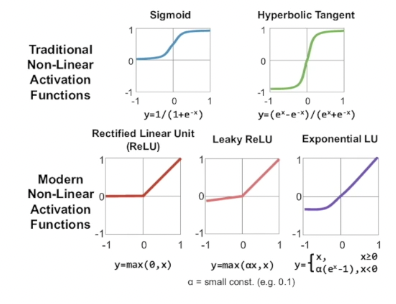  
